In [1]:
# Native imports
import sys
import os
import os.path
import json
from pprint import pprint
import urllib.request
import urllib.parse

# 3rd-party scraping/parsing imports
import requests
from bs4 import BeautifulSoup
import dateutil.parser as dt

# 3rd-party data science imports
import pandas as pd
import seaborn as sns

# Used to make the plots bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
FORCE_ORG_CATALOG_DOWNLOAD = True

In [3]:
ORGS_CATALOG_URL = 'https://callink.berkeley.edu/api/discovery/search/organizations?orderBy%5B0%5D=UpperName%20asc&top=1500'
ORG_CATEGORIES_URL = 'https://callink.berkeley.edu/api/discovery/organization/category?take=1000&orderByField=name'

ORG_JSON_FILE = 'callink-organizations.json'

ORG_URL = 'https://callink.berkeley.edu/organization/'
PROFILE_PIC_URL = 'https://se-infra-imageserver2.azureedge.net/clink/images/'

# Step 0: Download organization data


In [4]:
if FORCE_ORG_CATALOG_DOWNLOAD or not os.path.isfile(ORG_JSON_FILE):
    urllib.request.urlretrieve(ORGS_CATALOG_URL, ORG_JSON_FILE)

# Step 1: Load JSON files

In [5]:
# Load organizations file
with open(ORG_JSON_FILE) as fp:
    data = json.load(fp)
    
    num_orgs = data['@odata.count']
    print('Number of Organizations:', num_orgs)
    orgs = data['value']

Number of Organizations: 1418


# Step 2: Do some data cleaning and sanity checking

In [6]:
# Prep orgs dataframe
orgs_df = pd.DataFrame(orgs)
orgs_df = orgs_df.apply(pd.to_numeric, errors='ignore').convert_dtypes()
orgs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418 entries, 0 to 1417
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   @search.score         1418 non-null   Int64 
 1   Id                    1418 non-null   Int64 
 2   InstitutionId         1418 non-null   Int64 
 3   ParentOrganizationId  1418 non-null   Int64 
 4   BranchId              1418 non-null   Int64 
 5   Name                  1418 non-null   string
 6   ShortName             1151 non-null   string
 7   WebsiteKey            1418 non-null   string
 8   ProfilePicture        1161 non-null   string
 9   Description           1118 non-null   string
 10  Summary               1418 non-null   string
 11  CategoryIds           1418 non-null   object
 12  CategoryNames         1418 non-null   object
 13  Status                1418 non-null   string
 14  Visibility            1418 non-null   string
dtypes: Int64(5), object(2), string(8)
memo

In [7]:
orgs_df.head()

,@search.score,Id,InstitutionId,ParentOrganizationId,BranchId,Name,ShortName,WebsiteKey,ProfilePicture,Description,Summary,CategoryIds,CategoryNames,Status,Visibility
0,1,91590,1660,45852,45852,#Downcrew,DC,downcrew,599b19a9-8f62-4f4f-969d-a158e7e1f82b3424e143-b...,<p>We are a group of friends who are dedicated...,We are a group of friends who are dedicated to...,"[5113, 7850]","[Performing Arts Student Organizations, Underg...",Active,Public
1,1,46103,1660,45852,45852,*African American Student Development*,AASD,AASD,449d54f3-e84a-4c3f-be85-c910d57f743dc783ce86-a...,<NA>,African American Student Development creates p...,[5101],[Campus Departments],Active,Public
2,1,46114,1660,45852,45852,*Asian Pacific American Student Development*,apasd,apasd,019465ba-879b-40c1-b91f-f2ae4e9d08ece66a15fe-3...,<NA>,Asian Pacific American Student Development (AP...,[5101],[Campus Departments],Active,Public
3,1,132263,1660,45852,45852,*Berkeley Art Studio*,<NA>,artstudio,5f465b71-1993-4751-bd95-cff8618d810f26b687d7-c...,<p>The Berkeley Art Studio offers classes in c...,The Berkeley Art Studio offers classes in cera...,[5101],[Campus Departments],Active,Public
4,1,91365,1660,45852,45852,*Chicanx Latinx Student Development*,CLSD,CLSD,3e611db7-76de-466f-a8c6-096ebf893de879d5cf9c-c...,<NA>,The Chicana Latino Student Development Office ...,[5101],[Campus Departments],Active,Public


In [8]:
# List unique values and their counts
# NOTE: We are excluding the 'Category' keys because lists aren't hashable
print('Unique value counts')
print('===================')
print(pd.Series({c: len(orgs_df[c].unique()) for c in orgs_df if 'Category' not in c}))

Unique value counts
@search.score              1
Id                      1418
InstitutionId              1
ParentOrganizationId       1
BranchId                   1
Name                    1418
ShortName               1126
WebsiteKey              1418
ProfilePicture          1162
Description             1119
Summary                 1384
Status                     1
Visibility                 1
dtype: int64


In [9]:
# Keep only columns that have more than 1 unique value
wanted_org_cols = ['Id', 'Name', 'ShortName', 'WebsiteKey', 'ProfilePicture',
                   'Description', 'Summary', 'CategoryIds', 'CategoryNames']
orgs_df = orgs_df[wanted_org_cols]
orgs_df

,Id,Name,ShortName,WebsiteKey,ProfilePicture,Description,Summary,CategoryIds,CategoryNames
0,91590,#Downcrew,DC,downcrew,599b19a9-8f62-4f4f-969d-a158e7e1f82b3424e143-b...,<p>We are a group of friends who are dedicated...,We are a group of friends who are dedicated to...,"[5113, 7850]","[Performing Arts Student Organizations, Underg..."
1,46103,*African American Student Development*,AASD,AASD,449d54f3-e84a-4c3f-be85-c910d57f743dc783ce86-a...,<NA>,African American Student Development creates p...,[5101],[Campus Departments]
2,46114,*Asian Pacific American Student Development*,apasd,apasd,019465ba-879b-40c1-b91f-f2ae4e9d08ece66a15fe-3...,<NA>,Asian Pacific American Student Development (AP...,[5101],[Campus Departments]
3,132263,*Berkeley Art Studio*,<NA>,artstudio,5f465b71-1993-4751-bd95-cff8618d810f26b687d7-c...,<p>The Berkeley Art Studio offers classes in c...,The Berkeley Art Studio offers classes in cera...,[5101],[Campus Departments]
4,91365,*Chicanx Latinx Student Development*,CLSD,CLSD,3e611db7-76de-466f-a8c6-096ebf893de879d5cf9c-c...,<NA>,The Chicana Latino Student Development Office ...,[5101],[Campus Departments]
...,...,...,...,...,...,...,...,...,...
1413,91813,Zahanat,<NA>,zahanat,eda8071c-1591-4c8c-9ad6-aadf76d161bbb3af2a40-a...,"<p>Through dance, they seek to meld together a...",Zahanat is an all-male fusion dance team at UC...,"[5113, 7850]","[Performing Arts Student Organizations, Underg..."
1414,46461,Zawadi: Black LGBTQ Community at Berkeley,<NA>,zawadi,e543d5e4-0767-4729-ba73-7a25006c809e77ab99c4-b...,<p>We are interested in increasing visibility ...,"This group is a social, academic, and politica...","[2691, 7853]","[GSG - Graduate Student Groups, Cultural & Ide..."
1415,181872,Zeta Chi Consulting,ZC Consulting,zcconsulting,<NA>,<NA>,ZC Consulting seeks to bring together students...,"[5115, 7850]","[Professional Student Organizations, Undergrad..."
1416,91377,Zeta Tau Alpha,<NA>,zetataualpha,79cff071-d349-4dd8-8dc9-30e4307573b5b147b553-8...,<p>Mission Statement: To make a difference in ...,Zeta Tau Alpha is the intensifying of friendsh...,[5138],[CalGreeks Panhellenic Council (PHC) Sororities]


# Step 3: Scrape the data

In [42]:
'''
Strategy: Although we have to navigate into each link to get the email and any other important info,
the good part is we don't need to fully render the page despite CalLink being done in React.

'window.initialAppState' is the key, so we just need to fetch that for each organization and we're
good to go!
'''

# Make the needed folders for downloading "debug" files
COVER_PHOTOS_DIR = 'data/cover_pics/'
PROFILE_PHOTOS_DIR = 'data/profile_pics/'
APP_STATE_DIR = 'data/app_states/'

os.makedirs(COVER_PHOTOS_DIR, exist_ok=True)
os.makedirs(PROFILE_PHOTOS_DIR, exist_ok=True)
os.makedirs(APP_STATE_DIR, exist_ok=True)

def fetch_html_page(url):
    return requests.get(url).text.strip()

def fetch_init_app_state(soup):
    for element in soup.find_all('script'):
        if len(element.contents) > 0 and 'window.initialAppState' in element.contents[0]:
            json_str = element.contents[0].split(' = ')[1][:-1]
            return json.loads(json_str)
    return None

def safe_fetch(obj, key):
    return None if pd.isna(obj[key]) else obj[key].strip()

def process_org(org_row):
    
    # Non-nullable initial fields
    org_id         = safe_fetch(org_row, 'WebsiteKey')
    org_name       = safe_fetch(org_row, 'Name')
    org_summary    = safe_fetch(org_row, 'Summary')
    org_categories = [name.strip() for name in org_row.get('CategoryNames')]
    
    # Nullable initial fields
    org_short_name  = safe_fetch(org_row, 'ShortName')
    org_description = safe_fetch(org_row, 'Description')
    
    
    if not os.path.isfile(APP_STATE_DIR + f'{org_id}.json'):
        # Fetch the app state in the org page
        html = fetch_html_page(ORG_URL + org_id)
        soup = BeautifulSoup(html, 'html.parser')
        app_state = fetch_init_app_state(soup)

        # Save the app state for debugging purposes
        with open(APP_STATE_DIR + f'{org_id}.json', 'w') as fp:
            json.dump(app_state, fp)
    else:
        # Load the app state from the JSON file
        with open(APP_STATE_DIR + f'{org_id}.json', 'r') as fp:
            app_state = json.load(fp)
            
    # Shortcut to important organization info
    org_details = app_state['preFetchedData']['organization']
            
    if not os.path.isfile(COVER_PHOTOS_DIR + f'{org_id}-cover.jpg'):
        # Save the cover photo
        cover_photo_url = app_state['coverPhoto']['url'].strip()
        urllib.request.urlretrieve(cover_photo_url, COVER_PHOTOS_DIR + f'{org_id}-cover.jpg')
    
    if not os.path.isfile(PROFILE_PHOTOS_DIR + f'{org_id}-profile.jpg'):
        # Save the profile photo
        if org_details['profilePicture'] is not None:
            profile_photo_url = PROFILE_PIC_URL + org_details['profilePicture'].strip()
            urllib.request.urlretrieve(profile_photo_url, PROFILE_PHOTOS_DIR + f'{org_id}-profile.jpg')
    
    # Get the email, phone, and social media links
    email = safe_fetch(org_details, 'email')
    
    if (len(org_details['contactInfo']) > 1):
        print('ALERT - multi contact info', org_id)
    
    if (len(org_details['contactInfo']) == 1):
        contact_info_obj = org_details['contactInfo'][0]
        phone     = safe_fetch(contact_info_obj, 'phoneNumber')
        phone_ext = safe_fetch(contact_info_obj, 'extension')
    else:
        phone = None
        phone_ext = None
    
    if org_details['primaryContact'] is not None:
        primary_contact_name = f"{org_details['primaryContact']['firstName']} {org_details['primaryContact']['lastName']}".strip()
        primary_contact_email = org_details['primaryContact']['primaryEmailAddress'].strip()
    else:
        primary_contact_name = None
        primary_contact_email = None
    
    social_media_tag_map = [
        ('website', 'externalWebsite'),
        ('flickr', 'flickrUrl'),
        ('google-calendar', 'googleCalendarUrl'),
        ('google-plus', 'googlePlusUrl'),
        ('instagram', 'instagramUrl'),
        ('linkedin', 'linkedInUrl'),
        ('pinterest', 'pinterestUrl'),
        ('tumblr', 'tumblrUrl'),
        ('vimeo', 'vimeoUrl'),
        ('youtube', 'youtubeUrl'),
        ('facebook', 'facebookUrl'),
        ('twitter-url', 'twitterUrl'),
        ('twitter-user', 'twitterUserName')
    ]
    
    social_media = {}
    for (native_tag, alien_tag) in social_media_tag_map:
        smedia_obj = org_details['socialMedia']
        social_media[native_tag] = safe_fetch(smedia_obj, alien_tag)
        
    org_start_date = dt.parse(org_details['startDate'])
    if org_start_date.timestamp() < 0:
        org_start_date = None
    else:
        org_start_date = org_start_date.date()
    
    return {
        'id': org_id, 
        'name': org_name,
        'has-profile-pic': org_details['profilePicture'] is not None,
        'has-cover-pic': True,
        # NOTE: There hasn't been a case where an org has no cover photo as of yet.
        'start-date': org_start_date,
        'summary': org_summary,
        'categories': org_categories,
        'short-name': org_short_name,
        'description': org_description,
        'email': email,
        'phone': phone,
        'phone-ext': phone_ext,
        'social-media': social_media
    }

processed_org_data = []

for (index, row) in orgs_df.iterrows():
    try:
        processed_org = process_org(row)
    except:
        print("Unexpected error:", sys.exc_info()[0])
        print(f"Problematic organization: {row['WebsiteKey']}")
        raise
    processed_org_data += [processed_org]
    
    if ((index + 1) % 50 == 0):
        print(f'{(index + 1)} / {num_orgs} organizations processed')
print('All orgs processed!')

50 / 1418 organizations processed
100 / 1418 organizations processed
150 / 1418 organizations processed
200 / 1418 organizations processed
250 / 1418 organizations processed
300 / 1418 organizations processed
350 / 1418 organizations processed
400 / 1418 organizations processed
450 / 1418 organizations processed
500 / 1418 organizations processed
550 / 1418 organizations processed
600 / 1418 organizations processed
650 / 1418 organizations processed
700 / 1418 organizations processed
750 / 1418 organizations processed
800 / 1418 organizations processed
850 / 1418 organizations processed
900 / 1418 organizations processed
950 / 1418 organizations processed
1000 / 1418 organizations processed
1050 / 1418 organizations processed
1100 / 1418 organizations processed
1150 / 1418 organizations processed
1200 / 1418 organizations processed
1250 / 1418 organizations processed
1300 / 1418 organizations processed
1350 / 1418 organizations processed
1400 / 1418 organizations processed
All orgs pro

In [43]:
# Let's make a DataFrame from all this new data
new_orgs_df = pd.DataFrame(processed_org_data).convert_dtypes()
new_orgs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418 entries, 0 to 1417
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1418 non-null   string 
 1   name             1418 non-null   string 
 2   has-profile-pic  1418 non-null   boolean
 3   has-cover-pic    1418 non-null   boolean
 4   start-date       902 non-null    object 
 5   summary          1418 non-null   string 
 6   categories       1418 non-null   object 
 7   short-name       1151 non-null   string 
 8   description      1118 non-null   string 
 9   email            1102 non-null   string 
 10  phone            288 non-null    string 
 11  phone-ext        13 non-null     string 
 12  social-media     1418 non-null   object 
dtypes: boolean(2), object(3), string(8)
memory usage: 127.5+ KB


In [44]:
# Let's also make a "sub" DataFrame for the social media links
social_media_map = pd.DataFrame(processed_org_data)['social-media'].values.tolist()
orgs_social_df = pd.DataFrame(social_media_map).convert_dtypes()
orgs_social_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418 entries, 0 to 1417
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   website          1418 non-null   string
 1   flickr           1418 non-null   string
 2   google-calendar  1418 non-null   string
 3   google-plus      1418 non-null   string
 4   instagram        1418 non-null   string
 5   linkedin         1418 non-null   string
 6   pinterest        1418 non-null   string
 7   tumblr           1418 non-null   string
 8   vimeo            1418 non-null   string
 9   youtube          1418 non-null   string
 10  facebook         879 non-null    string
 11  twitter-url      217 non-null    string
 12  twitter-user     327 non-null    string
dtypes: string(13)
memory usage: 144.1 KB


# Step 4: Visualize and understand the data

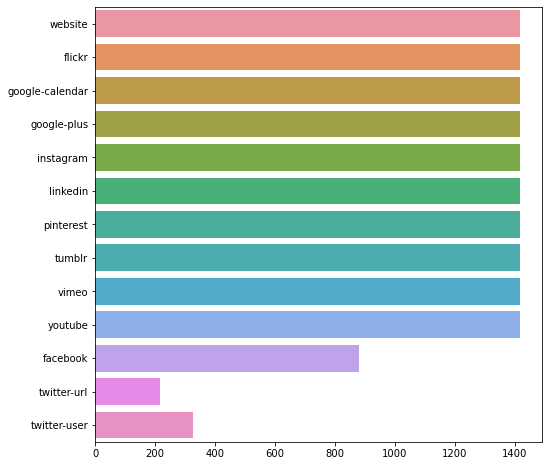

In [45]:
# Visual plot to show 
sns.barplot(y=orgs_social_df.count().index, x=orgs_social_df.count())

In [46]:
orgs_social_df.count()

website            1418
flickr             1418
google-calendar    1418
google-plus        1418
instagram          1418
linkedin           1418
pinterest          1418
tumblr             1418
vimeo              1418
youtube            1418
facebook            879
twitter-url         217
twitter-user        327
dtype: int64

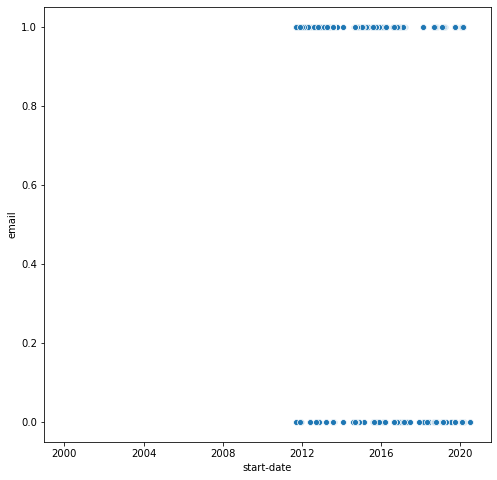

In [47]:
# Trying to see if the age of the club has any correlation to the club having an email or not
# Results: No correlation
sns.scatterplot(
    x=new_orgs_df['start-date'],
    y=new_orgs_df['email'].apply(lambda email: not pd.isna(email))
)

In [48]:
valid_start_date_indices = new_orgs_df['start-date'].notnull()
valid_start_dates = new_orgs_df['start-date'][valid_start_date_indices]

print('Oldest club start:', min(valid_start_dates))
print('Newest club start:', max(valid_start_dates))

Oldest club start: 2011-09-13
Newest club start: 2020-07-07


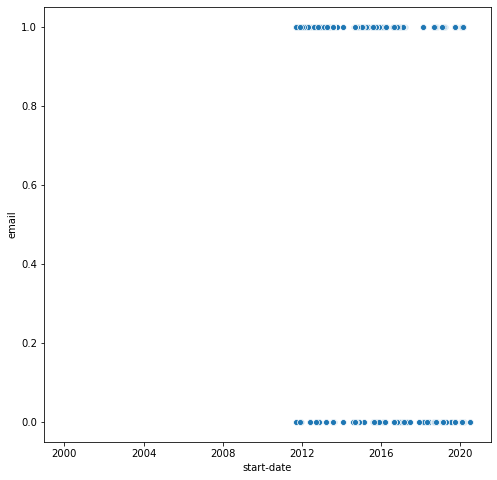

In [49]:
# Trying to see if the age of the club has any correlation to the club having an email or not
# Results: No correlation
sns.scatterplot(
    x=new_orgs_df['start-date'][valid_start_date_indices],
    y=new_orgs_df['email'].apply(lambda email: not pd.isna(email))
)

In [50]:
# Save all this data into a massive JSON file (NOT RECOMMENDED FOR PROD USE!!)

from datetime import datetime, date

OUTPUT_ORG_INFO_FILE = 'org-info.json'

# Allows handling of datetimes
def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        return obj.isoformat()
    raise TypeError ("Type %s not serializable" % type(obj))


with open(OUTPUT_ORG_INFO_FILE, 'w') as fp:
    json.dump(processed_org_data, fp, default=json_serial)

In [32]:
!cat org-info.json

[{"id": "downcrew", "name": "#Downcrew", "has-profile-pic": true, "has-cover-pic": true, "start-date": "2013-07-29", "summary": "We are a group of friends who are dedicated to establishing community through performance. #down", "categories": ["Performing Arts Student Organizations", "Undergraduate Organizations"], "short-name": "DC", "description": "<p>We are a group of friends who are dedicated to establishing community through performance.</p>", "email": "kimambrocio@berkeley.edu", "phone": "949-467-4006", "phone-ext": null, "social-media": {"website": null, "flickr": null, "google-calendar": null, "google-plus": null, "instagram": "http://www.instagram.com/dwncrw", "linkedin": null, "pinterest": null, "tumblr": null, "vimeo": null, "youtube": null, "facebook": null, "twitter-url": null, "twitter-user": null}}, {"id": "AASD", "name": "*African American Student Development*", "has-profile-pic": true, "has-cover-pic": true, "start-date": null, "summary": "African American Student Devel

role in local issues, COA, and AOA in order to improve participation in legislative activities through their school years and post-graduation. The Bay Area Optometric Council Mentorship Program at Berkeley seeks to involve students in local community events, legislative days, and general membership meeting business talks.</p>\r\n<p><strong>(3) Career Guidance:</strong></p>\r\n<p>The program&rsquo;s mentors come from a wide variety of backgrounds and have varying modes of practice and specialties. Students will gain career guidance by shadowing their mentors and learning about how they have achieved success. Students are encouraged to talk to all mentors in the program, not just their own, to be exposed to a larger variety career options. Mentors can share what they wished they knew as a student and to make the most of their educational experience for their future goals.</p>", "email": "baoc.rep@gmail.com", "phone": null, "phone-ext": null, "social-media": {"website": "https://sites.goo

instagram": null, "linkedin": null, "pinterest": null, "tumblr": null, "vimeo": null, "youtube": null, "facebook": null, "twitter-url": null, "twitter-user": null}}, {"id": "classicalforum", "name": "Classical Forum, The", "has-profile-pic": true, "has-cover-pic": true, "start-date": null, "summary": "The Classical Forum is dedicated to creating a space where people with an interest in classical civilizations can gather to discuss, listen, learn, and enjoy.", "categories": ["y ASUC Student Activity Groups", "Academic Student Organizations", "Undergraduate Organizations"], "short-name": "TCF", "description": null, "email": "classicalforumberkeley@gmail.com", "phone": null, "phone-ext": null, "social-media": {"website": null, "flickr": null, "google-calendar": null, "google-plus": null, "instagram": null, "linkedin": null, "pinterest": null, "tumblr": null, "vimeo": null, "youtube": null, "facebook": "https://www.facebook.com/groups/135567766468513/", "twitter-url": null, "twitter-user":

://flsaberkeley.weebly.com/", "flickr": null, "google-calendar": null, "google-plus": null, "instagram": "www.instagram.com/fiatlux_scholar_association", "linkedin": null, "pinterest": null, "tumblr": null, "vimeo": null, "youtube": null, "facebook": "https://www.facebook.com/groups/FLSABerkeley/", "twitter-url": null, "twitter-user": null}}, {"id": "fpsworkingroup", "name": "Filipino & Philippine Studies Working Group", "has-profile-pic": true, "has-cover-pic": true, "start-date": null, "summary": "The Filipino & Philippine Studies Working Group (FPS) offers an intellectual, cross-disciplinary space for graduate students, undergraduates, and faculty on new and critical scholarship in the fields.", "categories": ["Academic Student Organizations"], "short-name": "FPS", "description": "<p>The <strong>Filipino and Philippine Studies</strong> (FPS) working group offers an intellectual space for graduate students, undergraduates, and faculty to explore new and critical scholarship in the fi

 INSTITUTION OF EVOLUTION! Beta Chi Chapter at the University of California, Berkeley.", "categories": ["z ASUC Student Initiated Service Groups", "CalGreeks Multicultural Greek Council (MCGC) Fraternities & Sororities", "ABSA-Allocated Hearst Storage 2018-2019"], "short-name": "Lambdas", "description": "<p>On December 1, 1975, history was made &ndash; history on a college campus, which would transcend other colleges/universities throughout the United States; history which would have a positive impact on the Latino community and our nation; history which would forever change the Greek system, more specifically, the entity known as a fraternity. On December 1, 1975, Lambda Theta Phi was founded on the campu<span class=\"x_x_x_x_x_x_x_x_x_x_x_x_x_x_x_text_exposed_show\">s of Kean College in Union, New Jersey.<br /><br />The ideals of this brotherhood are the following: Academic Excellence; Brotherhood; Leadership; Latino Unity; Service. On a daily basis, our brothers live up to these ide

ucial mission: to equip motivated, ambitious, and eager students with the necessary technical skills to advance the modern technological landscape.", "categories": ["Technology Student Organizations", "Undergraduate Organizations"], "short-name": "PLEX", "description": null, "email": "info@plextech.berkeley.edu", "phone": null, "phone-ext": null, "social-media": {"website": "http://plextech.berkeley.edu", "flickr": null, "google-calendar": null, "google-plus": null, "instagram": null, "linkedin": "https://www.linkedin.com/company/64691722", "pinterest": null, "tumblr": null, "vimeo": null, "youtube": null, "facebook": "https://www.facebook.com/PlexTech-100710408175971/", "twitter-url": null, "twitter-user": null}}, {"id": "ballet", "name": "Pointe of Berkeley", "has-profile-pic": true, "has-cover-pic": true, "start-date": "2016-02-11", "summary": "UC Berkeley's ballet club that offers free drop-in ballet classes. Inclusive to all dance abilities, genders, and backgrounds!", "categories

<p>o&nbsp;&nbsp; To provide a space for members to propose, organize, and implement interventions related to racial justice, inclusion, diversity, and equity.</p>\r\n<p>o&nbsp;&nbsp; To apply the discussions and interventions to various settings, including but not limited to the Joint Medical Program, the School of Public Health, and the larger Bay Area community.&nbsp;</p>", "email": "mkane@berkeley.edu", "phone": null, "phone-ext": null, "social-media": {"website": null, "flickr": null, "google-calendar": null, "google-plus": null, "instagram": null, "linkedin": null, "pinterest": null, "tumblr": null, "vimeo": null, "youtube": null, "facebook": null, "twitter-url": null, "twitter-user": null}}, {"id": "studentsforwarrenatberkeley", "name": "Students for Warren at Berkeley", "has-profile-pic": true, "has-cover-pic": true, "start-date": "2014-10-08", "summary": "We are UC Berkeley students dedicated to electing Elizabeth Warren as President in 2020. We aim to mobilize and engage stude

# Step 5: Further analysis

In [20]:
print('Max length of club name:', new_orgs_df['name'].apply(len).max())
print('Max length of summary:', new_orgs_df['summary'].apply(len).max())
print('Max length of description:', new_orgs_df['description'].dropna().apply(len).max())

Max length of club name: 134
Max length of summary: 255
Max length of description: 16485


In [21]:
orgs_social_df['twitter-url'].dropna()

9          https://twitter.com/SERCBerkeley
10             https://twitter.com/TGIF_UCB
14       https://twitter.com/public_service
21          https://twitter.com/ababerkeley
42        http://twitter.com/#!/AEZBerkeley
                       ...                 
1304    https://twitter.com/Theater4Charity
1306             https://twitter.com/caltdx
1310       http://twitter.com/#!/AlBayanMag
1333       https://twitter.com/#!/rallycomm
1371              http://twitter.com/CalVSA
Name: twitter-url, Length: 73, dtype: string

In [22]:
orgs_social_df['twitter-user'].dropna()

9          SERCBerkeley
10             TGIF_UCB
12      CalCareerCenter
14       public_service
17      3DMC_UCBerkeley
             ...       
1376            CalVHIO
1379            cal_vmo
1406    @YouMeanMoreUCB
1408            ucb_dsa
1412          @ywcaberk
Name: twitter-user, Length: 226, dtype: string

In [23]:
orgs_social_df

,website,flickr,google-calendar,google-plus,instagram,linkedin,pinterest,tumblr,vimeo,youtube,facebook,twitter-url,twitter-user
0,<NA>,<NA>,<NA>,<NA>,http://www.instagram.com/dwncrw,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,https://campusclimate.berkeley.edu/students/ej...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,https://campusclimate.berkeley.edu/students/ej...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,http://artstudio.berkeley.edu,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://facebook.com/berkeleyartstudio,<NA>,<NA>
4,https://campusclimate.berkeley.edu/students/ej...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,<NA>,<NA>,<NA>,<NA>,http://www.instagram.com/ucbzahanat,<NA>,<NA>,<NA>,<NA>,<NA>,https://www.facebook.com/ucbzahanat,<NA>,<NA>
1414,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,https://www.facebook.com/groups/ucbzawadi/?ref...,<NA>,<NA>
1415,http://zc-consulting.org,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1416,http://berkeley.zetataualpha.org,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,https://www.youtube.com/channel/UCjGolwam4LPg6...,https://www.facebook.com/UCBerkeleyZetaTauAlpha,<NA>,<NA>


In [33]:
orgs_social_df['website'].dropna().head(100)

NameError: name 'orgs_social_df' is not defined

In [53]:
sum(new_orgs_df['email'].dropna().apply(lambda s: '@' not in s))

1